Question 1

In [ ]:
#importing libraries
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist, fashion_mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
#configuring wandb
%pip install wandb -q
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: me21b164 (me21b164-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
def prepare_dataset():
    """
    Prepares the Fashion MNIST dataset by performing the following steps:
    - Loads the dataset
    - Reshapes images into 1D vectors
    - Normalizes pixel values to [0,1]
    - Splits the training set into training and validation sets (90% train, 10% val)
    - Performs one-hot encoding of labels

    Returns:
        X_train.T, y_train_encoded, y_train.T, X_val.T, y_val.T, X_test.T, y_test.T, y_val_encoded
    """
    # Load the dataset
    (X, y), (X_test, y_test) = fashion_mnist.load_data()

    # Reshape images into 1D vectors
    X = X.reshape(X.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    # Normalize pixel values to [0,1]
    X = X / 255.0
    X_test = X_test / 255.0

    # Split training data into train and validation sets (90% train, 10% val)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

    # One-hot encoding for training labels
    y_train_encoded = np.zeros((10, y_train.shape[0]))
    y_train_encoded[y_train, np.arange(y_train.shape[0])] = 1

    # One-hot encoding for validation labels
    y_val_encoded = np.zeros((10, y_val.shape[0]))
    y_val_encoded[y_val, np.arange(y_val.shape[0])] = 1

    # Print dataset shapes for verification
    print("Number of examples in training set:")
    print("X_train:", X_train.shape)
    print("y_train_encoded:", y_train_encoded.shape)
    print("y_train:", y_train.shape)

    print("Number of examples in validation set:")
    print("X_val:", X_val.shape)
    print("y_val:", y_val.shape)

    print("Number of examples in test set:")
    print("X_test:", X_test.shape)
    print("y_test:", y_test.shape)

    return X_train.T, y_train_encoded, y_train.T, X_val.T, y_val.T, X_test.T, y_test.T, y_val_encoded

# Prepare the dataset
X_train, y_train_encoded, y_train, X_val, y_val, X_test, y_test, y_val_encoded = prepare_dataset()

# Define class names for Fashion MNIST dataset
num_classes = 10
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Number of examples in training set:
X_train: (54000, 784)
y_train_encoded: (10, 54000)
y_train: (54000,)
Number of examples in validation set:
X_val: (6000, 784)
y_val: (6000,)
Number of examples in test set:
X_test: (10000, 784)
y_test: (10000,)


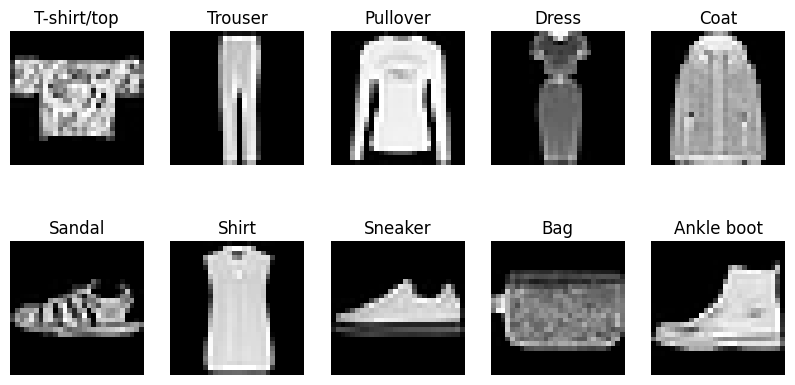

In [ ]:
# Initialize Weights & Biases (WandB) for logging
wandb.init(project="DA6401 ASSIGNMENT 01", entity="me21b164-indian-institute-of-technology-madras", name="Question 1")

# Select one sample per class for logging
indices = [list(y_train.T).index(i) for i in range(num_classes)]
images = [X_train.T[index].reshape((28, 28)) for index in indices]
captions = [class_names[y_train.T[index]] for index in indices]

# Create an array of images where one image per class is appended
ig = []
for i in range(num_classes):
    for j in range(len(y_train.T)):
        if y_train.T[j] == i:
            ig.append(X_train.T[j].reshape((28, 28)))
            break

# Plot the images
plt.figure(figsize=(10, 5))
for i in range(len(ig)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(ig[i], cmap='gray')
    plt.title(class_names[i])
    plt.axis("off")
plt.show()

# Log one sample image per class to WandB
wandb.run.name = "Question-1"
wandb.log({"Images from each class": [wandb.Image(img, caption=cap) for img, cap in zip(ig, class_names)]})
wandb.finish()

**Question 2**

In [ ]:
# Initialize Weights & Biases (W&B)
# Activation Functions
wandb.init(project="DA6401 ASSIGNMENT 01", entity="me21b164-indian-institute-of-technology-madras", name="Question 2")

def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Stability trick
    return exp_x / np.sum(exp_x)

# Initialization Functions

def initialize_weights(layer_sizes, init_method="he"):
    weights, biases = [], []
    for i in range(len(layer_sizes) - 1):
        input_dim, output_dim = layer_sizes[i], layer_sizes[i + 1]
        if init_method == "he":
            weights.append(np.random.randn(output_dim, input_dim) * np.sqrt(2. / input_dim))  # He initialization
        elif init_method == "xavier":
            weights.append(np.random.randn(output_dim, input_dim) * np.sqrt(1. / input_dim))  # Xavier for Sigmoid
        biases.append(np.zeros(output_dim))
    return weights, biases

# Feedforward Network

def forward_pass(x, weights, biases, activation="relu"):
    activations = []
    inputs = x
    for i in range(len(weights) - 1):  # Hidden layers
        z = np.dot(weights[i], inputs) + biases[i]
        if activation == "relu":
            inputs = relu(z)
        elif activation == "sigmoid":
            inputs = sigmoid(z)
        activations.append(inputs)

    # Output layer (Softmax)
    z = np.dot(weights[-1], inputs) + biases[-1]
    output = softmax(z)
    activations.append(output)

    return output, activations

# Evaluation Functions

def compute_loss(y_pred, y_true):
    return -np.sum(y_true * np.log(y_pred + 1e-9))  # Cross-Entropy Loss

def compute_accuracy(y_preds, y_trues):
    correct = sum(np.argmax(y_pred) == np.argmax(y_true) for y_pred, y_true in zip(y_preds, y_trues))
    return correct / len(y_trues)

# Data Loading and Preprocessing

def preprocess_fashion_mnist():
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train, x_test = x_train.reshape(-1, 784) / 255.0, x_test.reshape(-1, 784) / 255.0
    y_train, y_test = np.eye(10)[y_train], np.eye(10)[y_test]  # One-hot encoding
    return x_train, y_train, x_test, y_test

# Sample Run

# Define network architecture
hidden_layers = [128, 64]
layer_sizes = [784] + hidden_layers + [10]

# Choose activation function for hidden layers: "relu" or "sigmoid"
hidden_activation = "sigmoid"  # Change to "relu" if needed

# Select weight initialization based on activation function
init_method = "xavier" if hidden_activation == "sigmoid" else "he"

# Initialize weights and biases
weights, biases = initialize_weights(layer_sizes, init_method=init_method)

# Load and preprocess Fashion-MNIST data
x_train, y_train, x_test, y_test = preprocess_fashion_mnist()

# Perform forward pass on 10 test images
sample_x, sample_y = x_test[:10], y_test[:10]
predictions = [forward_pass(x, weights, biases, activation=hidden_activation)[0] for x in sample_x]

# Compute accuracy and loss
accuracy = compute_accuracy(predictions, sample_y)
loss = np.mean([compute_loss(y_pred, y_true) for y_pred, y_true in zip(predictions, sample_y)])

# Log results to Weights & Biases (W&B)
wandb.log({"Sample Accuracy": accuracy, "Sample Loss": loss})

# Print results
print(f"Sample Accuracy: {accuracy * 100:.2f}%")
print(f"Sample Loss: {loss:.4f}")


Sample Accuracy: 10.00%
Sample Loss: 2.4500
